In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Importing and exploring the dataset

In [52]:
data = pd.read_csv("/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv")
data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


Checking if all the cities has the data for a full range

In [53]:
data['City'].value_counts()

Springfield      18530
Portland         18530
Washington DC    18530
Washington       18530
Columbus         18530
                 ...  
Frankfurt         4136
Flagstaff         3574
Pristina          3427
Yerevan           3226
Bonn              3133
Name: City, Length: 321, dtype: int64

I wanted to develop a timeseries model for a single city. For this purpouse, I am taking the city Chennai (previously known as Madras), from Tamil Nadu, India. The city where I reside.

Chennai generally has only two season. It is hot for almost throughout the year, and rains in November/December months.

In [54]:
Bangladesh = data[data["City"] == "Dhaka"]
Bangladesh.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
251118,Asia,Bangladesh,NaN,Dhaka,1,1,1995,64.8
251119,Asia,Bangladesh,NaN,Dhaka,1,2,1995,58.4
251120,Asia,Bangladesh,NaN,Dhaka,1,3,1995,-99.0
251121,Asia,Bangladesh,NaN,Dhaka,1,4,1995,59.6
251122,Asia,Bangladesh,NaN,Dhaka,1,5,1995,64.9


Checking if all the year has complete records

In [55]:
Bangladesh["Year"].value_counts()

2007    366
2008    366
2004    366
2000    366
1996    366
2003    365
1999    365
1995    365
2006    365
2002    365
1998    365
2009    365
2005    365
2001    365
1997    365
2010    330
Name: Year, dtype: int64

In [56]:
Bangladesh.describe()

,Month,Day,Year,AvgTemperature
count,5810.000000,5810.000000,5810.000000,5810.000000
mean,6.491566,15.721170,2002.455250,10.109880
std,3.434458,8.796922,4.586929,86.724555
min,1.000000,1.000000,1995.000000,-99.000000
25%,4.000000,8.000000,1998.000000,-99.000000
50%,7.000000,16.000000,2002.000000,70.500000
75%,9.000000,23.000000,2006.000000,82.600000
max,12.000000,31.000000,2010.000000,91.400000


In [57]:
# Assuming df is your DataFrame and 'Avrtemp' is the name of the column
num_missing = (Bangladesh['AvgTemperature'] == -99).sum()

print(f"Count of values equal to -99 in the 'Avrtemp' column: {num_missing}")

Count of values equal to -99 in the 'Avrtemp' column: 2243


# Imputing missing values

The dataset has recorded missing values with the number -99. T

We will use forward fill method to impute the missing values for the dataset. That is, we will take the previously non missing value and fill it in the place of the missing value.

First replacing -99 with np.nan

In [58]:
"""-99 is put in place of missing values. 
We will have to forward fill with the last non missing value before -99
"""
Bangladesh["AvgTemperature"] = np.where(Bangladesh["AvgTemperature"] == -99, np.nan, Bangladesh["AvgTemperature"])
Bangladesh.isnull().sum()

Region               0
Country              0
State             5810
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature    2243
dtype: int64

Now using ffill() method to fill the np.nan that we created

In [59]:
Bangladesh["AvgTemperature"] = Bangladesh["AvgTemperature"].ffill()
Bangladesh.isnull().sum()

Region               0
Country              0
State             5810
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature       0
dtype: int64

Since there is no single column that contains the date, creating a new column called Time_steps to combine the year month and date fields

In [60]:
Bangladesh.dtypes
#converting time stamp into YYYYMMDD
Bangladesh["Time_steps"] = pd.to_datetime((Bangladesh.Year*10000 + Bangladesh.Month*100 + Bangladesh.Day).apply(str),format='%Y%m%d')
Bangladesh.head()


,Region,Country,State,City,Month,Day,Year,AvgTemperature,Time_steps
251118,Asia,Bangladesh,NaN,Dhaka,1,1,1995,64.8,1995-01-01
251119,Asia,Bangladesh,NaN,Dhaka,1,2,1995,58.4,1995-01-02
251120,Asia,Bangladesh,NaN,Dhaka,1,3,1995,58.4,1995-01-03
251121,Asia,Bangladesh,NaN,Dhaka,1,4,1995,59.6,1995-01-04
251122,Asia,Bangladesh,NaN,Dhaka,1,5,1995,64.9,1995-01-05


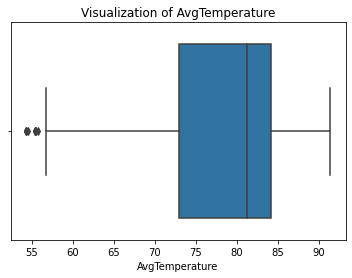

In [61]:
import seaborn as sns
# Plotting outliers
sns.boxplot(x=Bangladesh['AvgTemperature'])
plt.title(f'Visualization of AvgTemperature')
plt.show()

In [62]:
avr_temp_summary=Bangladesh['AvgTemperature']

In [63]:
# Removing outliers
Q1 = avr_temp_summary.quantile(0.25)
Q3 = avr_temp_summary.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Extracted outliers
# outliers_df = Regina[(avr_temp_summary < lower_bound) | (avr_temp_summary > upper_bound)]


# Filtering outliers
Bangladesh = Bangladesh[(avr_temp_summary >= lower_bound) & (avr_temp_summary <= upper_bound)]


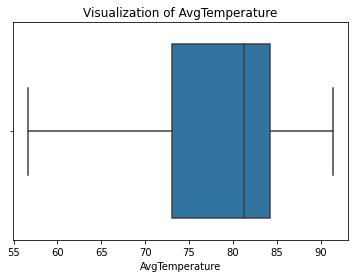

In [64]:
# Plotting after removing outliers
sns.boxplot(x=Bangladesh['AvgTemperature'])
plt.title(f'Visualization of AvgTemperature')
plt.show()

In [65]:
# droping state column
columns_to_drop = ['State']  # List of column names to drop
Bangladesh = Bangladesh.drop(columns=columns_to_drop)
Bangladesh.head()

,Region,Country,City,Month,Day,Year,AvgTemperature,Time_steps
251118,Asia,Bangladesh,Dhaka,1,1,1995,64.8,1995-01-01
251119,Asia,Bangladesh,Dhaka,1,2,1995,58.4,1995-01-02
251120,Asia,Bangladesh,Dhaka,1,3,1995,58.4,1995-01-03
251121,Asia,Bangladesh,Dhaka,1,4,1995,59.6,1995-01-04
251122,Asia,Bangladesh,Dhaka,1,5,1995,64.9,1995-01-05


In [66]:
#none to plot to the end, stat default value is 0
def plot_series(time, series, format="-", start=0, end=None):
    """to plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Year")
    plt.ylabel("Temprature")
    plt.grid(True)

Plotting the timeseries for the entire duration

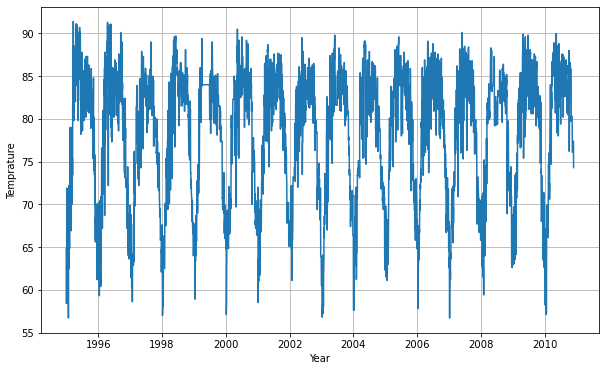

In [67]:
time_step = Bangladesh["Time_steps"].tolist()
temprature = Bangladesh["AvgTemperature"].tolist()

series = np.array(temprature)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

Plotting for recent one year only

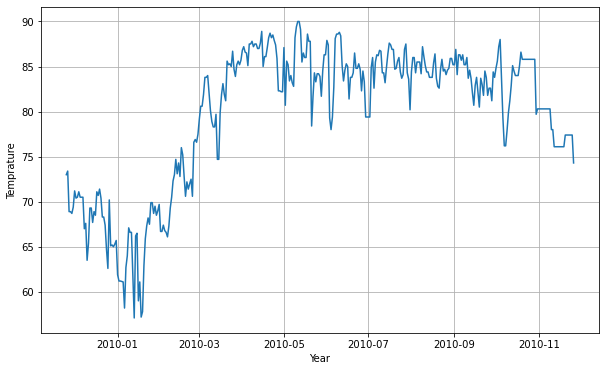

In [68]:
plt.figure(figsize=(10, 6))
plot_series(time[-365:], series[-365:])

There are totally 9,266 records on the dataset. We will keep 8000 records for training (85%) and keep remaining 15% for testing

In [69]:
#splitting the data into val and train 20, 80
split_index = int(len(series) * 0.8)
time_train = time[:split_index]
x_train = series[:split_index]
time_valid = time[split_index:]
x_valid = series[split_index:]


# Naive forecast

In naive forecast, we will take the record in month - 1 (the month previously) and assume that it will be carried forward for the next observation also.

In [70]:
naive_forecast = series[split_index - 1:-1]

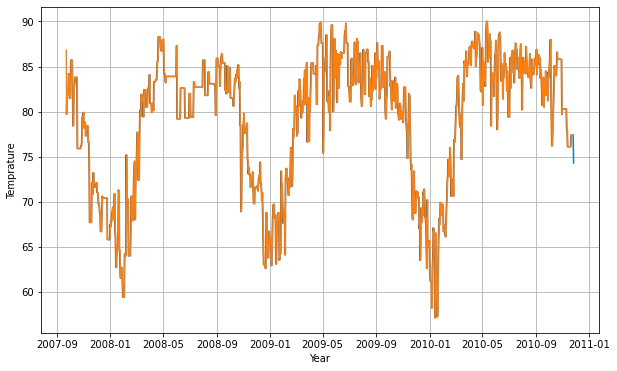

In [71]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Since the plot above is so crowded, we will take for a small section of the dataset and visualize it.

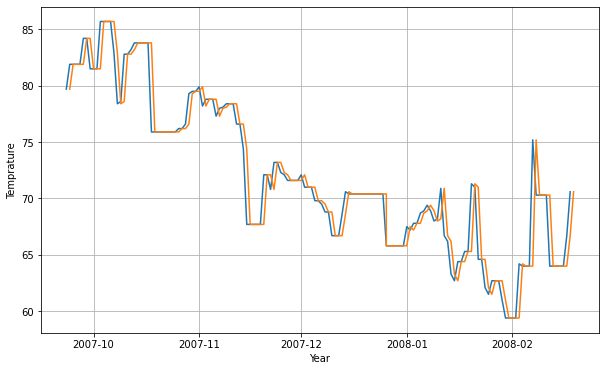

In [72]:
#Zoom in and see only few points
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [73]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

4.206077586206896
1.1861206896551721


# Moving average forecast

In moving average forecast, we will take the value of average for the previous window period and take it as the prediction for the next period.

In [74]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

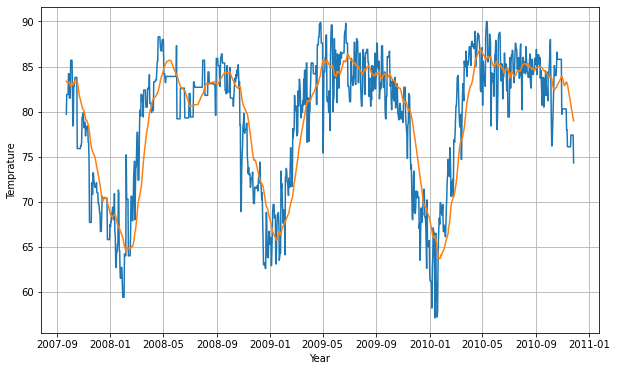

In [75]:
moving_avg = moving_average_forecast(series, 30)[split_index - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [76]:
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

13.00135572796935
2.843775862068966


## Differencing

We will use a technique called differencing to remove the trend and seasonality from the data. 
Here we difference the data between what the value was 365 days (1 year back). The differencing should always follow the seasonal pattern. 

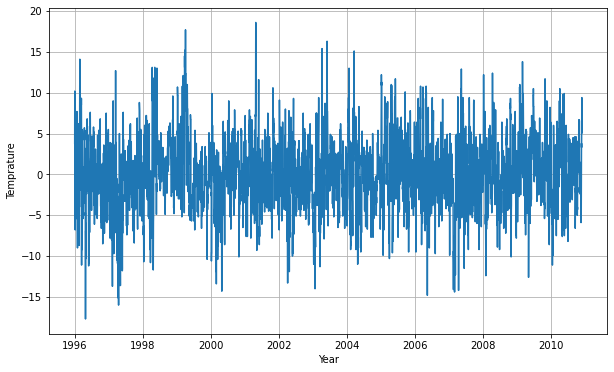

In [77]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

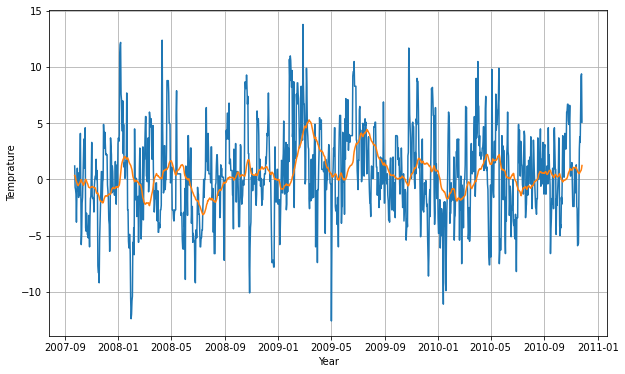

In [78]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_index - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_index - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

## Restoring trend and seasonality
But these are just the forecast of the differenced timeseries. To get the value for the original timeseries, we have to add back the value of t-365

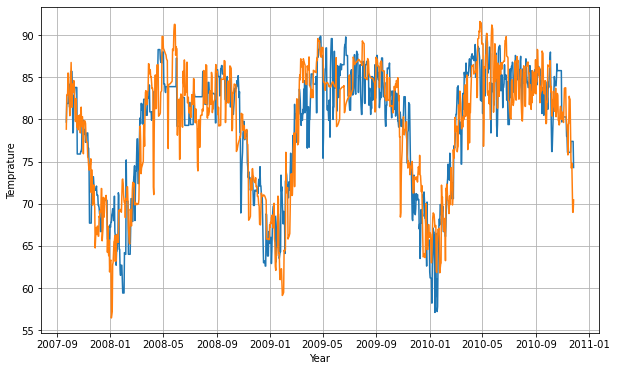

In [79]:
diff_moving_avg_plus_past = series[split_index - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [80]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

15.694280275862068
3.1095310344827585


## Smoothing with moving average again

The above plot has a lot of noise. To smooth it again, we do a moving average on that

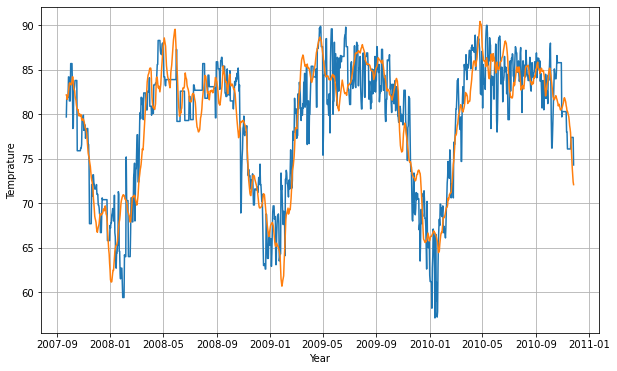

In [81]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_index - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [82]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

11.695448396551722
2.70296724137931


# How to prepare a window dataset?

A window dataset is used in the dataset prepration of the tensorflow. It yields a prefetched dataset with the x and y variables as tensors. 

### Step 1: Converting the numpy array into a tensor using tensor_slices

In [83]:
series1 = tf.expand_dims(series, axis=-1)
ds = tf.data.Dataset.from_tensor_slices(series1[:20])
for val in ds:
    print(val.numpy())


[64.8]
[58.4]
[58.4]
[59.6]
[64.9]
[64.9]
[71.9]
[71.3]
[64.3]
[66.6]
[70.6]
[65.9]
[67.]
[60.4]
[68.]
[66.7]
[66.7]
[65.5]
[66.2]
[66.2]


### Step 2: tf window option groups 5 (window size) into a single line

But for the last observations for which there are no observations to group will be kept as remaining as in the outupt of this cell

In [84]:
dataset = ds.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

[64.8] [58.4] [58.4] [59.6] [64.9] 
[58.4] [58.4] [59.6] [64.9] [64.9] 
[58.4] [59.6] [64.9] [64.9] [71.9] 
[59.6] [64.9] [64.9] [71.9] [71.3] 
[64.9] [64.9] [71.9] [71.3] [64.3] 
[64.9] [71.9] [71.3] [64.3] [66.6] 
[71.9] [71.3] [64.3] [66.6] [70.6] 
[71.3] [64.3] [66.6] [70.6] [65.9] 
[64.3] [66.6] [70.6] [65.9] [67.] 
[66.6] [70.6] [65.9] [67.] [60.4] 
[70.6] [65.9] [67.] [60.4] [68.] 
[65.9] [67.] [60.4] [68.] [66.7] 
[67.] [60.4] [68.] [66.7] [66.7] 
[60.4] [68.] [66.7] [66.7] [65.5] 
[68.] [66.7] [66.7] [65.5] [66.2] 
[66.7] [66.7] [65.5] [66.2] [66.2] 
[66.7] [65.5] [66.2] [66.2] 
[65.5] [66.2] [66.2] 
[66.2] [66.2] 
[66.2] 


### Step 3: Drop reminder set to True will drop the variables which are not having the grouping

In [85]:
dataset = ds.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

[64.8] [58.4] [58.4] [59.6] [64.9] 
[58.4] [58.4] [59.6] [64.9] [64.9] 
[58.4] [59.6] [64.9] [64.9] [71.9] 
[59.6] [64.9] [64.9] [71.9] [71.3] 
[64.9] [64.9] [71.9] [71.3] [64.3] 
[64.9] [71.9] [71.3] [64.3] [66.6] 
[71.9] [71.3] [64.3] [66.6] [70.6] 
[71.3] [64.3] [66.6] [70.6] [65.9] 
[64.3] [66.6] [70.6] [65.9] [67.] 
[66.6] [70.6] [65.9] [67.] [60.4] 
[70.6] [65.9] [67.] [60.4] [68.] 
[65.9] [67.] [60.4] [68.] [66.7] 
[67.] [60.4] [68.] [66.7] [66.7] 
[60.4] [68.] [66.7] [66.7] [65.5] 
[68.] [66.7] [66.7] [65.5] [66.2] 
[66.7] [66.7] [65.5] [66.2] [66.2] 


### Step 4: flat map option will group the 5 observation in a single tensor variable

In [86]:
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[[64.8]
 [58.4]
 [58.4]
 [59.6]
 [64.9]]
[[58.4]
 [58.4]
 [59.6]
 [64.9]
 [64.9]]
[[58.4]
 [59.6]
 [64.9]
 [64.9]
 [71.9]]
[[59.6]
 [64.9]
 [64.9]
 [71.9]
 [71.3]]
[[64.9]
 [64.9]
 [71.9]
 [71.3]
 [64.3]]
[[64.9]
 [71.9]
 [71.3]
 [64.3]
 [66.6]]
[[71.9]
 [71.3]
 [64.3]
 [66.6]
 [70.6]]
[[71.3]
 [64.3]
 [66.6]
 [70.6]
 [65.9]]
[[64.3]
 [66.6]
 [70.6]
 [65.9]
 [67. ]]
[[66.6]
 [70.6]
 [65.9]
 [67. ]
 [60.4]]
[[70.6]
 [65.9]
 [67. ]
 [60.4]
 [68. ]]
[[65.9]
 [67. ]
 [60.4]
 [68. ]
 [66.7]]
[[67. ]
 [60.4]
 [68. ]
 [66.7]
 [66.7]]
[[60.4]
 [68. ]
 [66.7]
 [66.7]
 [65.5]]
[[68. ]
 [66.7]
 [66.7]
 [65.5]
 [66.2]]
[[66.7]
 [66.7]
 [65.5]
 [66.2]
 [66.2]]


### Step 5: map option will split the variables into X and y variables

In [87]:
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[64.8]
 [58.4]
 [58.4]
 [59.6]] [[64.9]]
[[58.4]
 [58.4]
 [59.6]
 [64.9]] [[64.9]]
[[58.4]
 [59.6]
 [64.9]
 [64.9]] [[71.9]]
[[59.6]
 [64.9]
 [64.9]
 [71.9]] [[71.3]]
[[64.9]
 [64.9]
 [71.9]
 [71.3]] [[64.3]]
[[64.9]
 [71.9]
 [71.3]
 [64.3]] [[66.6]]
[[71.9]
 [71.3]
 [64.3]
 [66.6]] [[70.6]]
[[71.3]
 [64.3]
 [66.6]
 [70.6]] [[65.9]]
[[64.3]
 [66.6]
 [70.6]
 [65.9]] [[67.]]
[[66.6]
 [70.6]
 [65.9]
 [67. ]] [[60.4]]
[[70.6]
 [65.9]
 [67. ]
 [60.4]] [[68.]]
[[65.9]
 [67. ]
 [60.4]
 [68. ]] [[66.7]]
[[67. ]
 [60.4]
 [68. ]
 [66.7]] [[66.7]]
[[60.4]
 [68. ]
 [66.7]
 [66.7]] [[65.5]]
[[68. ]
 [66.7]
 [66.7]
 [65.5]] [[66.2]]
[[66.7]
 [66.7]
 [65.5]
 [66.2]] [[66.2]]


### Step 6: shuffle option will shuffle the dataset into random order.

Till the previous step, the observation would have been in the correct order. the shuffle will ensure that the data are randomly mixed up

In [88]:
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[64.9]
 [64.9]
 [71.9]
 [71.3]] [[64.3]]
[[71.9]
 [71.3]
 [64.3]
 [66.6]] [[70.6]]
[[64.9]
 [71.9]
 [71.3]
 [64.3]] [[66.6]]
[[71.3]
 [64.3]
 [66.6]
 [70.6]] [[65.9]]
[[58.4]
 [59.6]
 [64.9]
 [64.9]] [[71.9]]
[[65.9]
 [67. ]
 [60.4]
 [68. ]] [[66.7]]
[[67. ]
 [60.4]
 [68. ]
 [66.7]] [[66.7]]
[[64.3]
 [66.6]
 [70.6]
 [65.9]] [[67.]]
[[59.6]
 [64.9]
 [64.9]
 [71.9]] [[71.3]]
[[58.4]
 [58.4]
 [59.6]
 [64.9]] [[64.9]]
[[64.8]
 [58.4]
 [58.4]
 [59.6]] [[64.9]]
[[70.6]
 [65.9]
 [67. ]
 [60.4]] [[68.]]
[[66.7]
 [66.7]
 [65.5]
 [66.2]] [[66.2]]
[[66.6]
 [70.6]
 [65.9]
 [67. ]] [[60.4]]
[[68. ]
 [66.7]
 [66.7]
 [65.5]] [[66.2]]
[[60.4]
 [68. ]
 [66.7]
 [66.7]] [[65.5]]


### Step 7: Batch option will put the variables into mini-batches suitable for training. It will group both X and y into mini batches

In [89]:
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print("*"*25)

x =  [[[71.3]
  [64.3]
  [66.6]
  [70.6]]

 [[58.4]
  [59.6]
  [64.9]
  [64.9]]]
y =  [[[65.9]]

 [[71.9]]]
*************************
x =  [[[64.9]
  [71.9]
  [71.3]
  [64.3]]

 [[67. ]
  [60.4]
  [68. ]
  [66.7]]]
y =  [[[66.6]]

 [[66.7]]]
*************************
x =  [[[66.6]
  [70.6]
  [65.9]
  [67. ]]

 [[70.6]
  [65.9]
  [67. ]
  [60.4]]]
y =  [[[60.4]]

 [[68. ]]]
*************************
x =  [[[68. ]
  [66.7]
  [66.7]
  [65.5]]

 [[64.8]
  [58.4]
  [58.4]
  [59.6]]]
y =  [[[66.2]]

 [[64.9]]]
*************************
x =  [[[64.9]
  [64.9]
  [71.9]
  [71.3]]

 [[65.9]
  [67. ]
  [60.4]
  [68. ]]]
y =  [[[64.3]]

 [[66.7]]]
*************************
x =  [[[60.4]
  [68. ]
  [66.7]
  [66.7]]

 [[59.6]
  [64.9]
  [64.9]
  [71.9]]]
y =  [[[65.5]]

 [[71.3]]]
*************************
x =  [[[66.7]
  [66.7]
  [65.5]
  [66.2]]

 [[58.4]
  [58.4]
  [59.6]
  [64.9]]]
y =  [[[66.2]]

 [[64.9]]]
*************************
x =  [[[71.9]
  [71.3]
  [64.3]
  [66.6]]

 [[64.3]
  [66.6]
 

Window size is how many observations in the past do you want to see before making a prediction.
Batch size is similar to mini-batches set while training the neural network

In [90]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [91]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    To create a window dataset given a numpy as input
    
    Returns: A prefetched tensorflow dataset
    """
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

## Finding the correct learning rate

Using a call back for LearningRateScheduler(). For every epoch this just changes the learning rate a little so that the learning rate varies from 1e-8 to 1e-6

Also a new loss function Huber() is introduced which is less sensitive to outliers.

In [92]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4640,)
Epoch 1/100
18/18 [==============================] - 1s 35ms/step - loss: 43.2034 - mae: 43.7034 - lr: 1.0000e-08
Epoch 2/100
18/18 [==============================] - 1s 38ms/step - loss: 33.9575 - mae: 34.4573 - lr: 1.1220e-08
Epoch 3/100
18/18 [==============================] - 1s 38ms/step - loss: 27.6275 - mae: 28.1257 - lr: 1.2589e-08
Epoch 4/100
18/18 [==============================] - 1s 38ms/step - loss: 21.4975 - mae: 21.9936 - lr: 1.4125e-08
Epoch 5/100
18/18 [==============================] - 1s 38ms/step - loss: 16.7881 - mae: 17.2827 - lr: 1.5849e-08
Epoch 6/100
18/18 [==============================] - 1s 39ms/step - loss: 13.9759 - mae: 14.4700 - lr: 1.7783e-08
Epoch 7/100
18/18 [==============================] - 1s 44ms/step - loss: 12.6337 - mae: 13.1234 - lr: 1.9953e-08
Epoch 8/100
18/18 [==============================] - 1s 40ms/step - loss: 12.1837 - mae: 12.6684 - l

We plot this on a semilog axis

(1e-08, 0.0001, 0.0, 60.0)

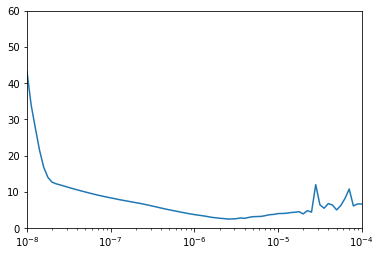

In [93]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

We take the step where the learning rate drops the steepest to train our neural network.

In [94]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
  tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
46/46 [==============================] - 1s 17ms/step - loss: 20.7963 - mae: 21.2843
Epoch 2/500
46/46 [==============================] - 1s 17ms/step - loss: 13.2786 - mae: 13.7596
Epoch 3/500
46/46 [==============================] - 1s 18ms/step - loss: 11.6602 - mae: 12.1369
Epoch 4/500
46/46 [==============================] - 1s 18ms/step - loss: 10.6038 - mae: 11.0796
Epoch 5/500
46/46 [==============================] - 1s 18ms/step - loss: 9.8400 - mae: 10.3155
Epoch 6/500
46/46 [==============================] - 1s 19ms/step - loss: 9.2319 - mae: 9.7070
Epoch 7/500
46/46 [==============================] - 1s 17ms/step - loss: 8.6803 - mae: 9.1547
Epoch 8/500
46/46 [==============================] - 1s 17ms/step - loss: 8.1733 - mae: 8.6470
Epoch 9/500
46/46 [==============================] - 1s 18ms/step - loss: 7.7215 - mae: 8.1949
Epoch 10/500
46/46 [==============================] - 1s 17ms/step - loss: 7.3107 - mae: 7.7836
Epoch 11/500
46/46 [====================

In [95]:
def model_forecast(model, series, window_size):
    """
    Given a model object and a series for it to predict, this function will return the prediction
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [96]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_index - window_size:-1, -1, 0]

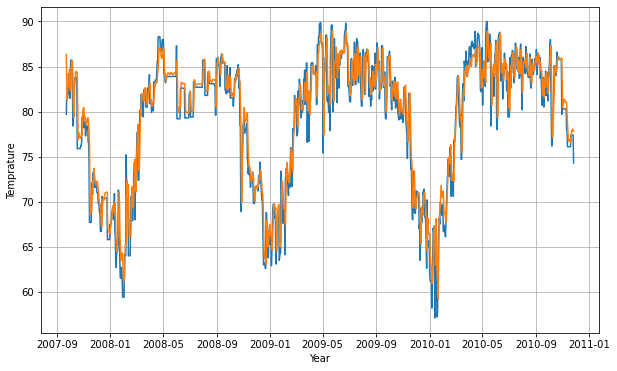

In [97]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [98]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.5464958

<Figure size 432x288 with 0 Axes>

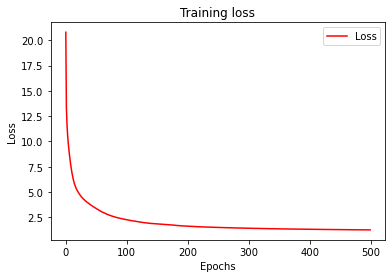

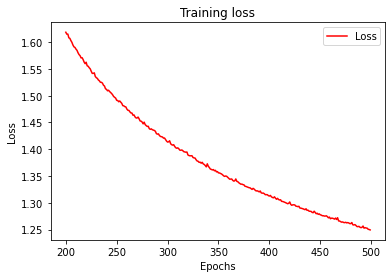

<Figure size 432x288 with 0 Axes>

In [99]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


In [103]:
# printing the predicted and actual numbers together
data = {'Date': time_valid, 'Actual': x_valid, 'Predicted': rnn_forecast}
comparison_df = pd.DataFrame(data)
comparison_df.tail()

,Date,Actual,Predicted
1155,2010-11-22,77.4,77.834656
1156,2010-11-23,77.4,77.889809
1157,2010-11-24,77.4,78.060913
1158,2010-11-25,77.4,77.836250
1159,2010-11-26,74.3,77.837219
